# Image generation of FASHION-MNIST via β-VAE

Loading FAHSION MNIST dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print(f'train set: {len(trainset)} x {trainset[0][0].shape}')
print(f'test set : {len(testset)} x {testset[0][0].shape}')
print(f'classes  : {trainset.classes}')
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.35MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

train set: 60000 x torch.Size([1, 28, 28])
test set : 10000 x torch.Size([1, 28, 28])
classes  : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


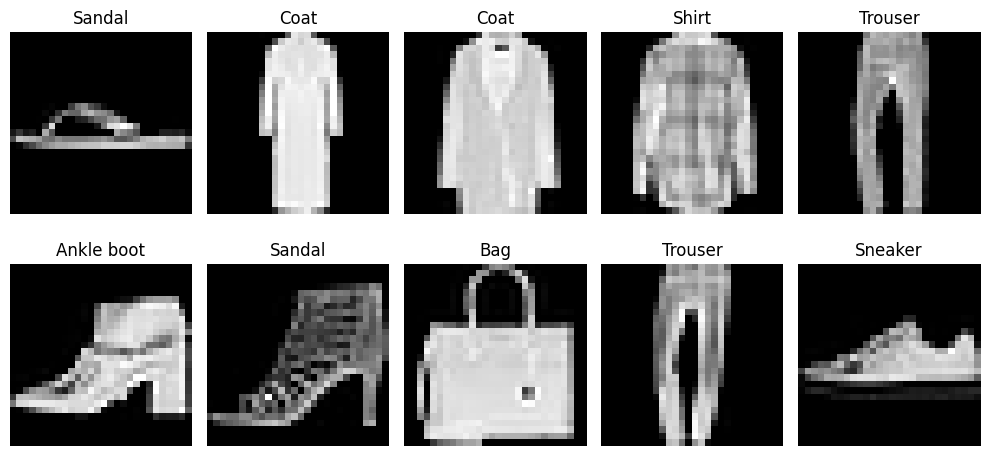

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for i in range(10):
    img, lbl = trainset[torch.randint(0, len(trainset), (1,)).item()]
    plt.subplot(2,5,i+1)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.title(trainset.classes[lbl])
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Theory**

**Encoder and decoder of VAE are decoded as follows.**
- Encoder (Gaussian distribution)：$$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| \mu,\sigma^2{\bf I}), 　s.t.　\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x}). $$
- Decoder (Bernoulli distribution)：$$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}| \lambda), 　s.t.　\lambda=f_{\theta}({\bf z}).$$
<br>

**ELBO (Evidence Lower BOund) is represented like below.**  The first and the second term are corresponding to (minus) reconstruction loss and KL divergence, respectively. For the implementation of β-VAE, the coefficient β(>1) in the regularisation term of the objective function is needed in order to make the model more disentangled.


$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -\beta D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]
 $$  

#**MODEL**

In [ ]:
import torch
import torch.nn as nn


class BetaVAE(nn.Module):
    def __init__(self, d_latent=128):
        super(BetaVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, d_latent * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_latent, 512),
            nn.ReLU(),
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2) # make sure we get a positive semi-definite cov-matrix.
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


class BetaVAELoss(nn.Module):
    def __init__(self, beta=4):
        super(BetaVAELoss, self).__init__()
        self.beta = beta
        self.bce_loss = nn.BCELoss(reduction='sum')

    def forward(self, r_data, true_data, mu, logvar):
        divergance = torch.mean(-0.5 * torch.sum((1 + logvar - mu ** 2 - logvar.exp()), dim = 1), dim = 0)
        reconstruction = self.bce_loss(r_data, true_data)
        return reconstruction + self.beta * divergance

# **TRAINING**

In [ ]:
d_latent = 128
n_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE(d_latent).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = BetaVAELoss(beta = 4)

In [ ]:
from tqdm import tqdm

def run_epoch(mode, dataloader, bar_desc='', display_bar=True):
    if mode=='train':
        model.train()
    elif mode=='validate':
        model.eval()
    else:
        raise 'Unexpected mode'

    if display_bar:
        bar = tqdm(total=len(dataloader), desc=bar_desc, postfix='', leave=True, position=0)

    sum_loss = 0
    for batch_i, (batch, labels) in enumerate(dataloader):
        batch = batch.to(device)

        if mode=='train': optimizer.zero_grad()

        r_batch, mu, logvar = model(batch)
        loss = criterion(r_batch, batch, mu, logvar)
        sum_loss += loss.item()

        if mode=='train':
            loss.backward()
            optimizer.step()

        if display_bar:
            avg_loss = sum_loss / (batch_i + 1)
            bar.set_postfix_str(f'loss:{loss.item():.5f}, avg-loss:{avg_loss:.5f}')
            bar.update(1)

    return sum_loss / len(dataloader)



results = []
for epoch in range(n_epochs):
    res = run_epoch('train', train_loader, bar_desc= f'Training [{epoch+1}/{n_epochs}]')
    results.append(res)

    res = run_epoch('validate', test_loader, bar_desc=f'Validate [{epoch+1}/{n_epochs}]')
    results.append(res)
    print()

    torch.save(model.state_dict(), f'vae.pkl')

Validate [1/50]: 100%|██████████| 157/157 [00:02<00:00, 76.57it/s, loss:3762.82910, avg-loss:14816.99806]


Validate [2/50]: 100%|██████████| 157/157 [00:01<00:00, 78.80it/s, loss:3687.31177, avg-loss:14547.74329]


Validate [3/50]: 100%|██████████| 157/157 [00:02<00:00, 62.68it/s, loss:3624.13672, avg-loss:14365.33150]


Validate [4/50]: 100%|██████████| 157/157 [00:02<00:00, 76.85it/s, loss:3566.93359, avg-loss:14212.78136]


Validate [5/50]: 100%|██████████| 157/157 [00:02<00:00, 71.18it/s, loss:3574.90186, avg-loss:14160.48753]


Validate [6/50]: 100%|██████████| 157/157 [00:02<00:00, 78.37it/s, loss:3570.88794, avg-loss:14066.91521]


Validate [7/50]: 100%|██████████| 157/157 [00:02<00:00, 56.75it/s, loss:3554.59399, avg-loss:14068.27552]


Validate [8/50]: 100%|██████████| 157/157 [00:02<00:00, 77.51it/s, loss:3556.44531, avg-loss:14016.89681]


Validate [9/50]: 100%|██████████| 157/157 [00:02<00:00, 63.96it/s, loss:3543.69116, avg-loss:13972.45327]


Validate [10/50]: 100%|██████████| 157/157 [00:01<00:00, 78.68it/s, loss:3586.42920, avg-loss:14052.41194]


Validate [11/50]: 100%|██████████| 157/157 [00:02<00:00, 77.42it/s, loss:3522.70044, avg-loss:13911.86208]


Validate [12/50]: 100%|██████████| 157/157 [00:02<00:00, 71.98it/s, loss:3520.79492, avg-loss:13921.33099]


Validate [13/50]: 100%|██████████| 157/157 [00:02<00:00, 77.11it/s, loss:3534.86328, avg-loss:13974.23403]


Validate [14/50]: 100%|██████████| 157/157 [00:02<00:00, 66.38it/s, loss:3528.00879, avg-loss:13928.30435]


Validate [15/50]: 100%|██████████| 157/157 [00:02<00:00, 77.95it/s, loss:3534.57349, avg-loss:13928.16217]


Validate [16/50]: 100%|██████████| 157/157 [00:02<00:00, 77.43it/s, loss:3499.59277, avg-loss:13839.26460]


Validate [17/50]: 100%|██████████| 157/157 [00:02<00:00, 77.46it/s, loss:3526.29077, avg-loss:13941.16168]


Validate [18/50]: 100%|██████████| 157/157 [00:02<00:00, 77.57it/s, loss:3559.39624, avg-loss:13962.05638]


Validate [19/50]: 100%|██████████| 157/157 [00:02<00:00, 65.63it/s, loss:3501.07788, avg-loss:13811.00772]


Validate [20/50]: 100%|██████████| 157/157 [00:01<00:00, 79.26it/s, loss:3534.66528, avg-loss:13938.96661]


Validate [21/50]: 100%|██████████| 157/157 [00:02<00:00, 72.79it/s, loss:3517.98242, avg-loss:13851.18601]


Validate [22/50]: 100%|██████████| 157/157 [00:02<00:00, 77.18it/s, loss:3503.13623, avg-loss:13797.76475]


Validate [23/50]: 100%|██████████| 157/157 [00:02<00:00, 78.32it/s, loss:3501.80835, avg-loss:13861.48969]


Validate [24/50]: 100%|██████████| 157/157 [00:02<00:00, 66.99it/s, loss:3502.23169, avg-loss:13789.05615]


Validate [25/50]: 100%|██████████| 157/157 [00:02<00:00, 77.64it/s, loss:3521.23828, avg-loss:13825.92717]


Validate [26/50]: 100%|██████████| 157/157 [00:02<00:00, 70.33it/s, loss:3521.54102, avg-loss:13846.65241]


Validate [27/50]: 100%|██████████| 157/157 [00:02<00:00, 76.26it/s, loss:3529.71777, avg-loss:13858.47728]


Validate [28/50]: 100%|██████████| 157/157 [00:02<00:00, 77.56it/s, loss:3496.22266, avg-loss:13782.23442]


Validate [29/50]: 100%|██████████| 157/157 [00:02<00:00, 68.43it/s, loss:3562.18311, avg-loss:14090.20263]


Validate [30/50]: 100%|██████████| 157/157 [00:02<00:00, 78.06it/s, loss:3523.74023, avg-loss:13849.56261]


Validate [31/50]: 100%|██████████| 157/157 [00:02<00:00, 67.77it/s, loss:3523.82568, avg-loss:13880.96584]


Validate [32/50]: 100%|██████████| 157/157 [00:02<00:00, 77.94it/s, loss:3496.52393, avg-loss:13779.72172]


Validate [33/50]: 100%|██████████| 157/157 [00:01<00:00, 78.91it/s, loss:3528.16162, avg-loss:13903.38017]


Validate [34/50]: 100%|██████████| 157/157 [00:02<00:00, 67.81it/s, loss:3504.37744, avg-loss:13878.37548]


Validate [35/50]: 100%|██████████| 157/157 [00:02<00:00, 76.78it/s, loss:3519.25586, avg-loss:13816.84188]


Validate [36/50]: 100%|██████████| 157/157 [00:02<00:00, 68.63it/s, loss:3532.68799, avg-loss:13856.40209]


Validate [37/50]: 100%|██████████| 157/157 [00:02<00:00, 78.02it/s, loss:3502.10547, avg-loss:13775.10173]


Validate [38/50]: 100%|██████████| 157/157 [00:02<00:00, 77.95it/s, loss:3499.55298, avg-loss:13742.25453]


Validate [39/50]: 100%|██████████| 157/157 [00:02<00:00, 78.44it/s, loss:3494.08936, avg-loss:13769.26318]


Validate [40/50]: 100%|██████████| 157/157 [00:02<00:00, 76.26it/s, loss:3507.11523, avg-loss:13747.29048]


Validate [41/50]: 100%|██████████| 157/157 [00:02<00:00, 59.59it/s, loss:3481.90356, avg-loss:13751.93050]


Validate [42/50]: 100%|██████████| 157/157 [00:02<00:00, 59.49it/s, loss:3524.94409, avg-loss:13812.00878]


Validate [43/50]: 100%|██████████| 157/157 [00:02<00:00, 77.32it/s, loss:3492.76709, avg-loss:13777.36683]


Validate [44/50]: 100%|██████████| 157/157 [00:02<00:00, 73.28it/s, loss:3502.91382, avg-loss:13772.20970]


Validate [45/50]: 100%|██████████| 157/157 [00:02<00:00, 78.09it/s, loss:3484.01025, avg-loss:13781.09543]


Validate [46/50]: 100%|██████████| 157/157 [00:02<00:00, 77.27it/s, loss:3499.27539, avg-loss:13814.51446]


Validate [47/50]: 100%|██████████| 157/157 [00:02<00:00, 72.46it/s, loss:3491.88281, avg-loss:13774.60407]


Validate [48/50]: 100%|██████████| 157/157 [00:02<00:00, 78.16it/s, loss:3486.20020, avg-loss:13743.91302]


Validate [49/50]: 100%|██████████| 157/157 [00:02<00:00, 64.31it/s, loss:3477.00684, avg-loss:13739.61478]


Validate [50/50]: 100%|██████████| 157/157 [00:02<00:00, 77.51it/s, loss:3497.77954, avg-loss:13745.46253]

Training [1/50]: 100%|██████████| 938/938 [16:36<00:00,  1.06s/it, loss:7236.33057, avg-loss:15530.98073]


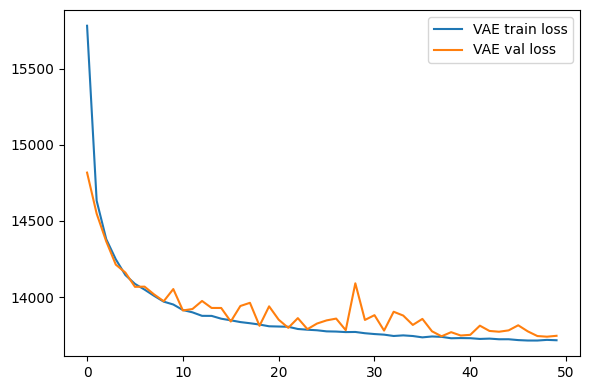

In [ ]:
train_losses, val_losses = [], []

for i in range(len(results) // 2):
  train_losses.append(results[2*i])
  val_losses.append(results[2*i+1])

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='VAE train loss')
plt.plot(val_losses, label='VAE val loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Visualization of reconstructed image**

Original image

In [ ]:
rnd_indices =  torch.randint(0, len(testset), (100,)).tolist()

def plot_100_sample(data):
    plt.figure(figsize=(10,10))
    for i in range(100):
        img, lbl = data[i]
        if type(lbl) is int:
            lbl = trainset.classes[lbl]
        plt.subplot(10, 10, i+1)
        plt.imshow(img.permute(1,2,0), cmap='gray')
        plt.title(lbl)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Training [1/50]:   0%|          | 0/938 [17:06<?, ?it/s]


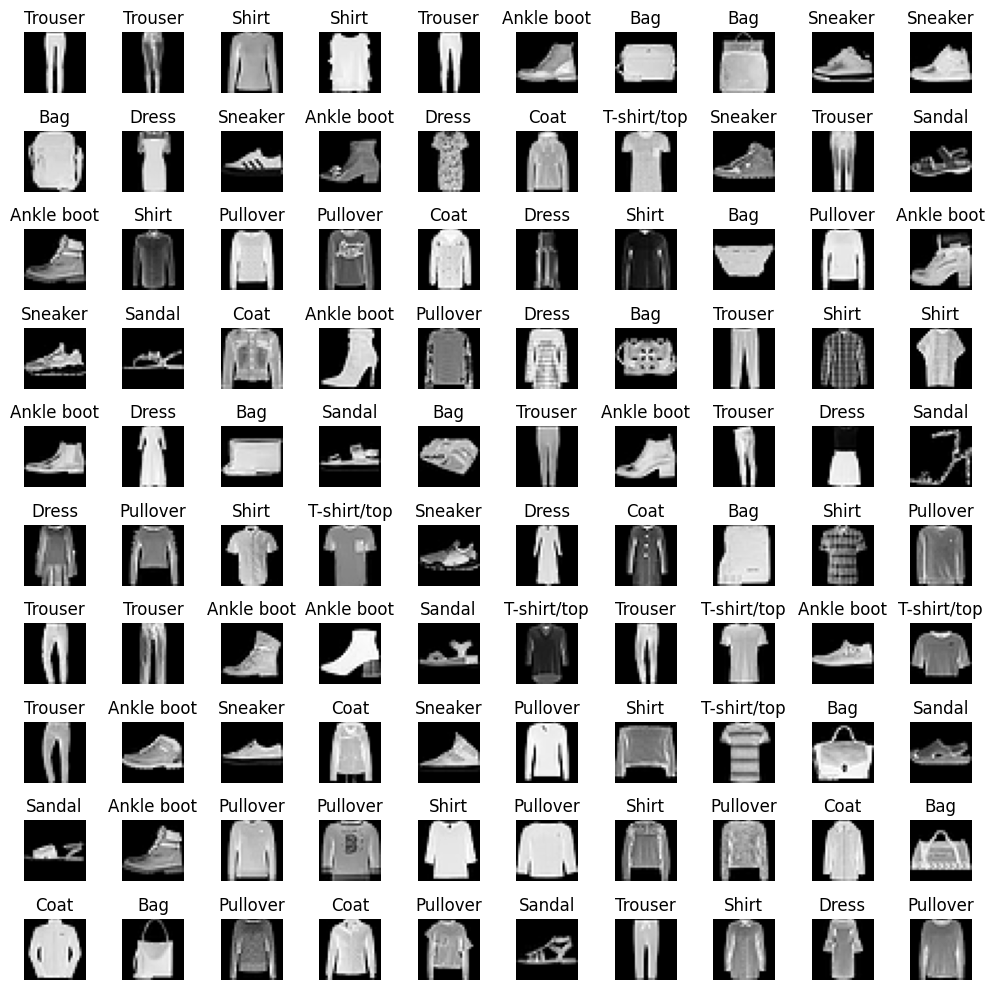

In [ ]:
plot_100_sample([testset[i] for i in rnd_indices])

Reconstructed image

In [ ]:
reconstructed_testset = []

for (batch, labels) in tqdm(test_loader, desc='Reconstruction'):
    with torch.no_grad():
        batch = batch.to(device)
        r_batch, _, _ = model(batch)
        r_batch = r_batch.detach().cpu()
        for i in range(r_batch.size(0)):
            reconstructed_testset.append((r_batch[i,:,:,:], labels[i].item()))

Reconstruction: 100%|██████████| 157/157 [00:01<00:00, 98.52it/s]


Training [1/50]:  73%|███████▎  | 683/938 [17:11<06:25,  1.51s/it, loss:14100.46875, avg-loss:14486.07449]


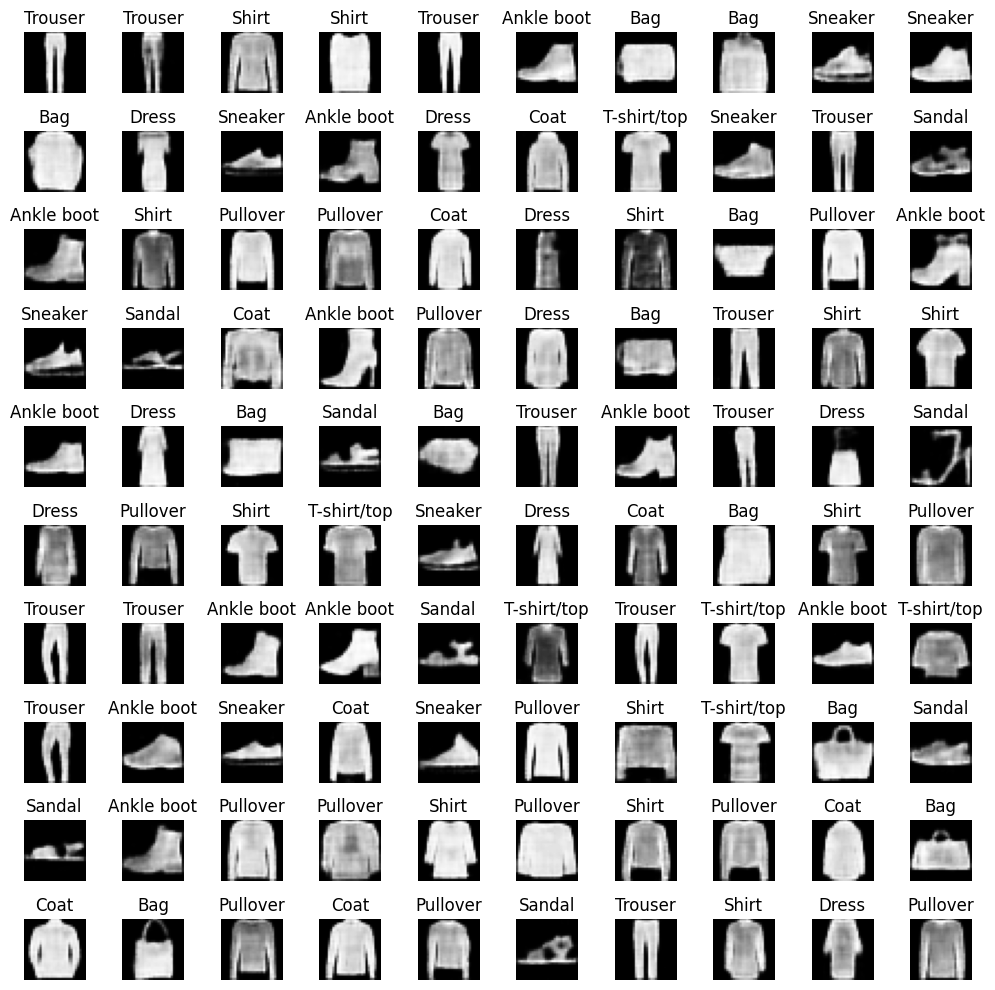

In [ ]:
plot_100_sample([reconstructed_testset[i] for i in rnd_indices])

Random sampling from latent variable

In [ ]:
random_generated = []

with torch.no_grad():
    z = torch.randn(len(testset), d_latent).to(device)  # Random sample from N(0, 1)
    r_batch = model.decoder(z).detach().cpu()
    for i in range(r_batch.size(0)):
        random_generated.append((r_batch[i,:,:,:], 'unknown'))

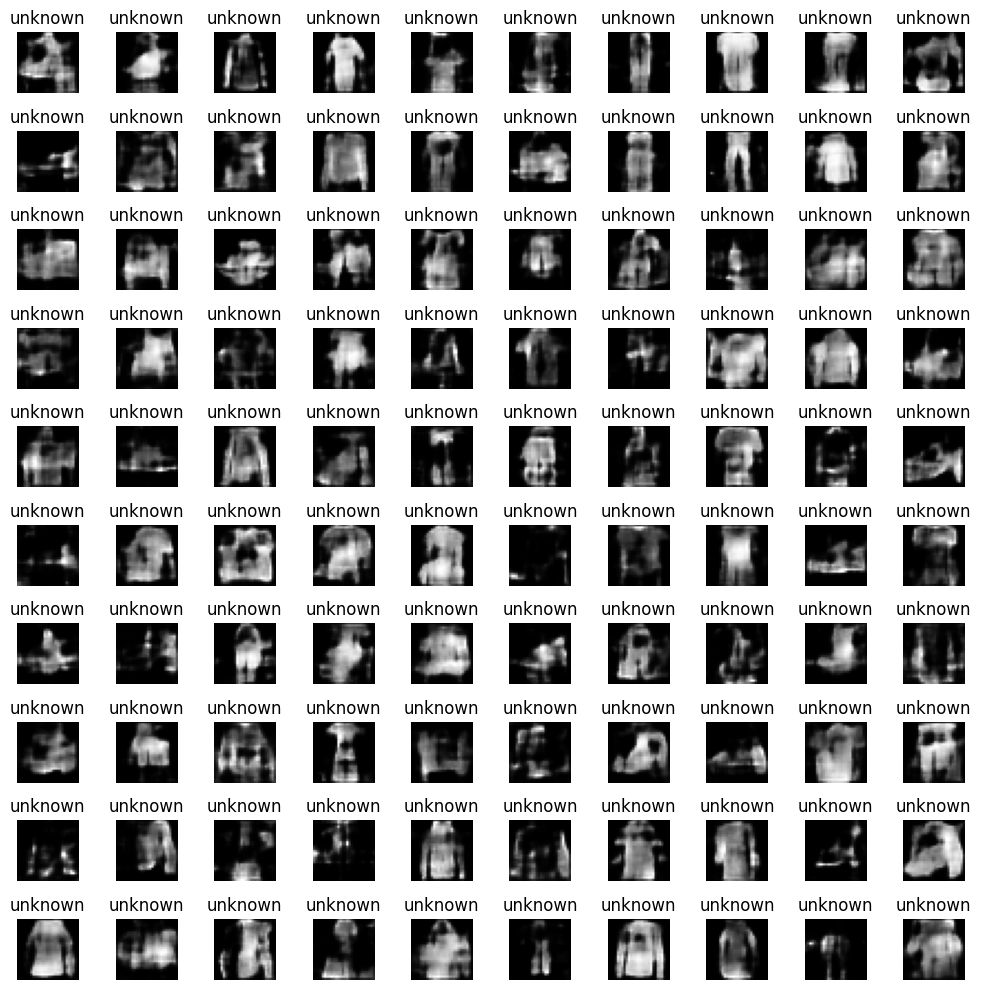

In [ ]:
plot_100_sample(random_generated)

# Compute FID



$$
\text{FID} = || \mu_r - \mu_g ||^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2 (\Sigma_r \Sigma_g)^{1/2})
$$


In [ ]:
from scipy import linalg
import numpy as np

def FID(imageset1, imageset2):
    s1 = torch.stack([sample[0].flatten() for sample in imageset1])
    s2 = torch.stack([sample[0].flatten() for sample in imageset2])

    mu1 = s1.mean(dim=0)
    mu2 = s2.mean(dim=0)
    diff = mu1 - mu2

    sigma1 = torch.cov(s1.T)
    sigma2 = torch.cov(s2.T)
    covmean, _ = linalg.sqrtm(sigma1.mm(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    if not np.isfinite(covmean).all():
        tr_covmean = np.sum(np.sqrt(((np.diag(sigma1) * eps) * (np.diag(sigma2) * eps)) / (eps * eps)))

    return float(diff.dot(diff).item() + sigma1.trace() + sigma2.trace() - 2 * tr_covmean)



In [ ]:
print('FID(real testset, reconstructed set):\n\t', FID(testset, reconstructed_testset))

FID(real testset, reconstructed set):
	 2.0385284423828125


In [ ]:
print('FID(real testset, random generated):\n\t', FID(testset, random_generated))

FID(real testset, random generated):
	 42.62757110595703


In [ ]:
print('FID(random generated, reconstructed set):\n\t', FID(random_generated, reconstructed_testset))

FID(random generated, reconstructed set):
	 41.032432556152344
